In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

## Visualize the datasets

Plot the dust deposition rate of the empirical dataset in the measurement locations and the simulated data on the global grid.

In [4]:
df_empirical_Holocene = pd.read_csv("df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv("df_empirical_LGM.csv")

In [5]:
world_map = gpd.read_file(geodatasets.get_path('naturalearth.land'))

In [6]:
def plot_dust_deposition_map(df, title, name_to_save, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar = 3.2):
    """Generate a map plot of dust deposition based on the provided dataframe.

    Parameters:
    - df (pandas DataFrame): The dataframe containing the dust deposition data.
    - title(str): The title to be displayed on the plot.
    - name_to_save (str): The filename to save the generated map plot.
    - label_str (str, optional): The column name in the dataframe to use for labeling the data on the plot. Defaults to 'log_dep'.
    - measure_units (str, optional): The units of measurement for the dust flux. Defaults to 'Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]'.
    - limit_bar (float, optional): The limit value for the colorbar on the plot. Defaults to 3.2."""

    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set limits and ticks
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Plot world map
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Plot the GeoDataFrame
    df_dust_geopandas.plot(column=label_str,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='viridis',
                           vmin=-limit_bar,
                           vmax=limit_bar,
                           linewidth=0.005,
                           markersize=100)

    # Set labels and title
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # Save and show the plot
    plt.savefig(f"{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return


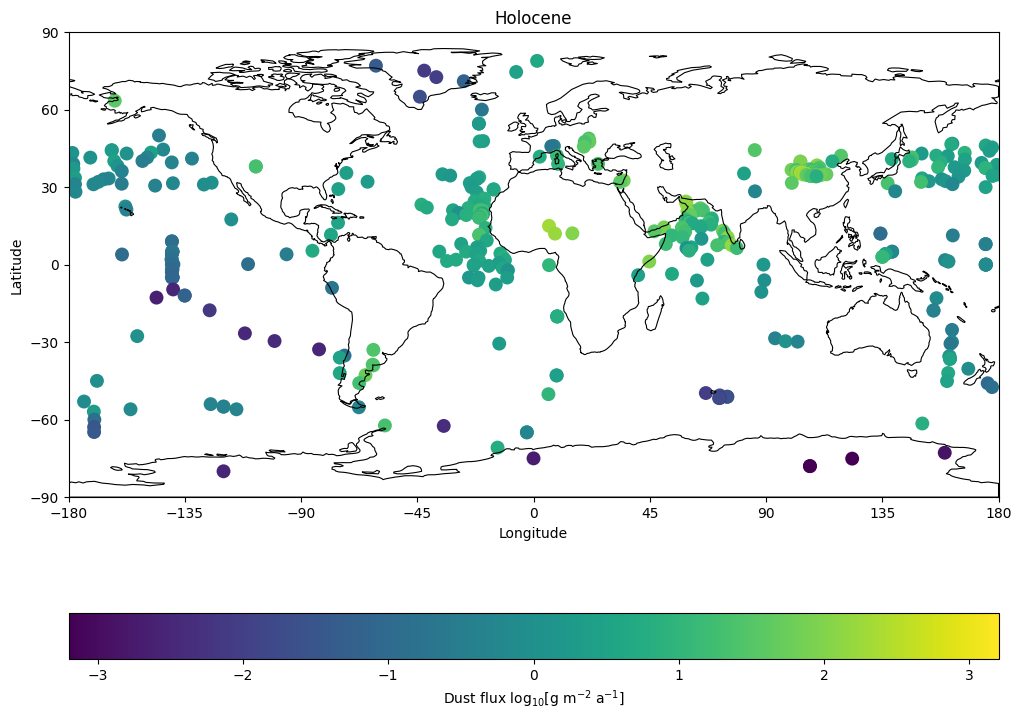

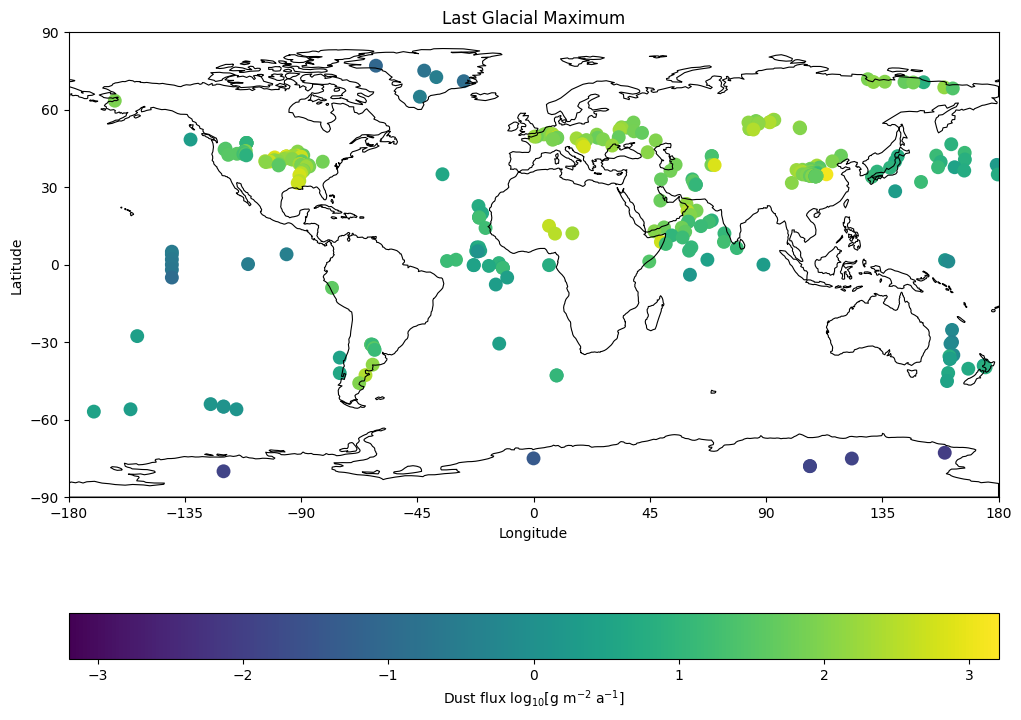

In [7]:
plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Holocene',
                         name_to_save='DATA_MAP_HOLOCENE')

plot_dust_deposition_map(df=df_empirical_LGM,
                         title='Last Glacial Maximum',
                         name_to_save='DATA_MAP_LGM')

## Create and visualize the global grid

The global grid for the predictions consists of 3-degree spacing.

In [8]:
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([ xx.reshape(-1), yy.reshape(-1) ])
df_gpd_global_grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1]))
df_global_grid = pd.DataFrame({
    'lon': df_gpd_global_grid.geometry.x,
    'lat': df_gpd_global_grid.geometry.y
})

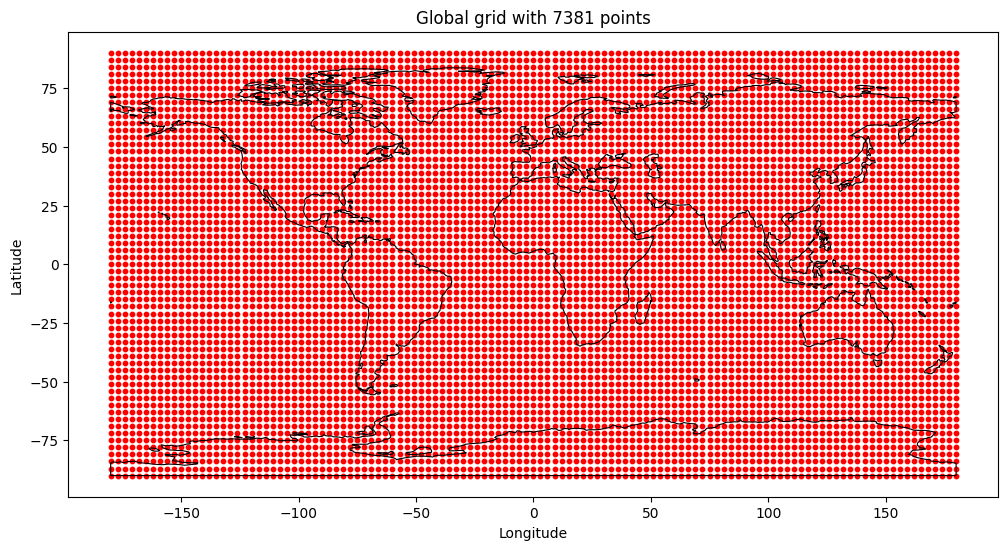

In [9]:
fig, ax = plt.subplots(figsize=(12,10))
world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)
df_gpd_global_grid.plot(ax=ax, color='red', markersize=10, marker ='o')

ax.set(xlabel='Longitude', ylabel='Latitude',
       title=f'Global grid with {df_gpd_global_grid.shape[0]} points')
plt.show()

## Analyse global deposition rate with nearest neighbours

The dust deposition rate will be estimated by averaging the values of the $k$ nearest neigbours.

In [10]:
df_global_grid

,lon,lat
0,-180.0,-90.0
1,-177.0,-90.0
2,-174.0,-90.0
3,-171.0,-90.0
4,-168.0,-90.0
...,...,...
7376,168.0,90.0
7377,171.0,90.0
7378,174.0,90.0
7379,177.0,90.0


Voy a cambiar la funcion de distancia euclidiana pues entrega grados y yo voy a usar radianes, por lo que voy a convertir la lon y lat a radianes

In [19]:
grados2radianes = (3.1415 / 180)

In [11]:
def distance_euclidean(x, y):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    lon1, lat1 = x
    lon2, lat2 = y

    lon1 = lon1 * grados2radianes
    lon2 = lon2 * grados2radianes

    lat1 = lat1 * grados2radianes
    lat2 = lat2 * grados2radianes

    distance = np.sqrt( (lon1 - lon2)**2 + (lat1 - lat2)**2)
    return distance

No voy a usar el radio de la tierra pues ahi la distancia geodesica me regresaria km y yo solo necesito los radianes

In [12]:
def distance_geodesic(x: tuple[float, float], y: tuple[float, float]):
    """
    Calculate the geodesic distance between two points on Earth.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """

    lon1, lat1 = x
    lon2, lat2 = y

    lon1 = lon1 * grados2radianes
    lon2 = lon2 * grados2radianes

    lat1 = lat1 * grados2radianes
    lat2 = lat2 * grados2radianes

    distance = np.arccos((np.sin(lat1)*np.sin(lat2))+(np.cos(lat1)*np.cos(lat2)*np.cos(lon1 - lon2)) )
    return distance

In [13]:
def nearest_neighbour_estimation(df, x, k, dist):
    """
    Perform a k nearest neighbour estimation.

    Parameters:
    df : pandas.DataFrame
        The database.
    x : Iterable
        Location for the estimation.
    k : int
        The number of neighbours to consider.
    dist : str
        The type of distance definition.
    """
    
    if dist == "geodesic":
        distance_fun = distance_geodesic
    else:
        distance_fun = distance_euclidean
    
    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))
    
    sorted_indices = np.argsort(distances)
    nearest_points = sorted_indices[:k]
    
    values_neighbours = df.loc[nearest_points, "log_dep"]
    estimation = np.average(values_neighbours)
    
    return estimation

In [16]:
# Choose the number of neighbours to include in the estimation
n_neighbours = 5

In [15]:
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

print(1)

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')

df_global_grid["est_hol"] = estimations_holocene
df_global_grid["est_lgm"] = estimations_lgm

1


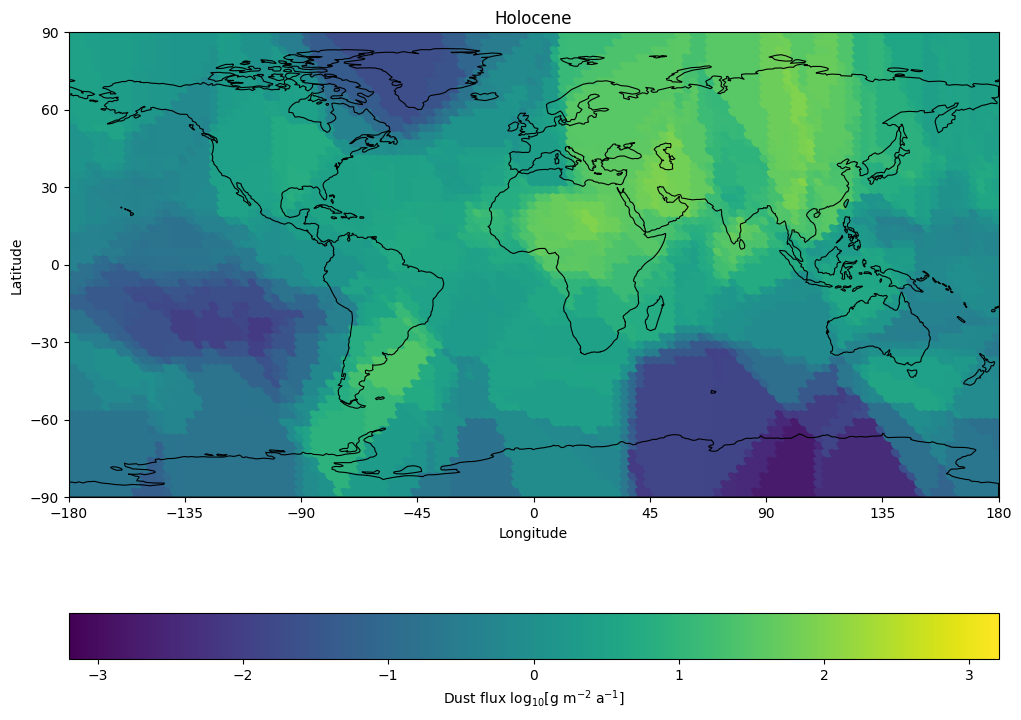

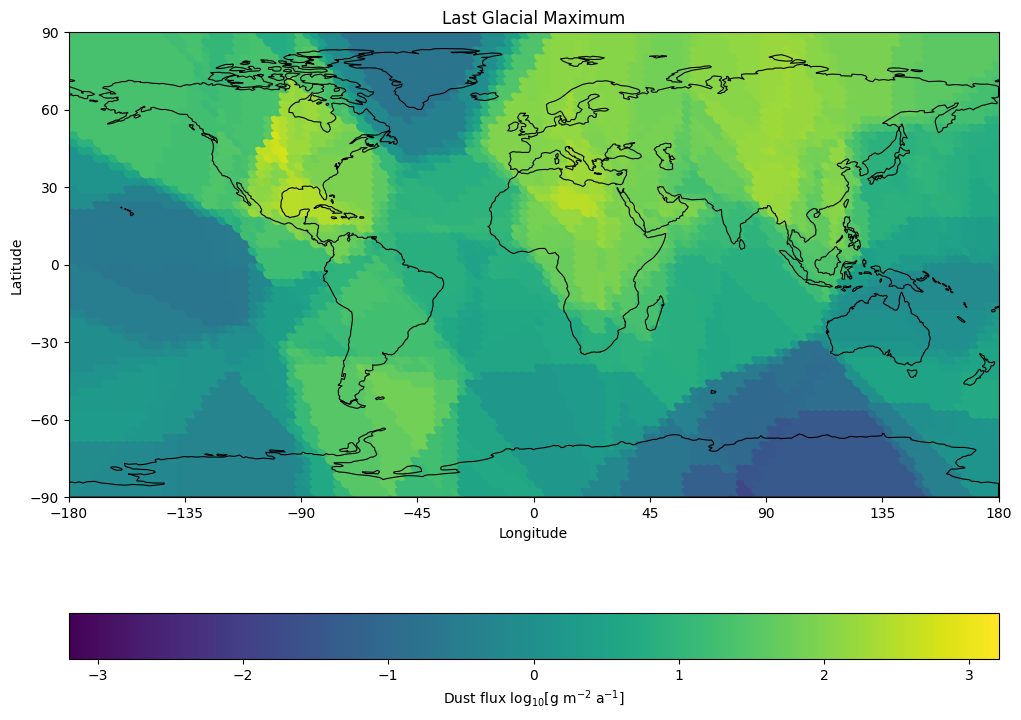

In [16]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm')

In [17]:
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

print(1)

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist="geodesic")
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

df_global_grid["est_hol"] = estimations_holocene
df_global_grid["est_lgm"] = estimations_lgm

1


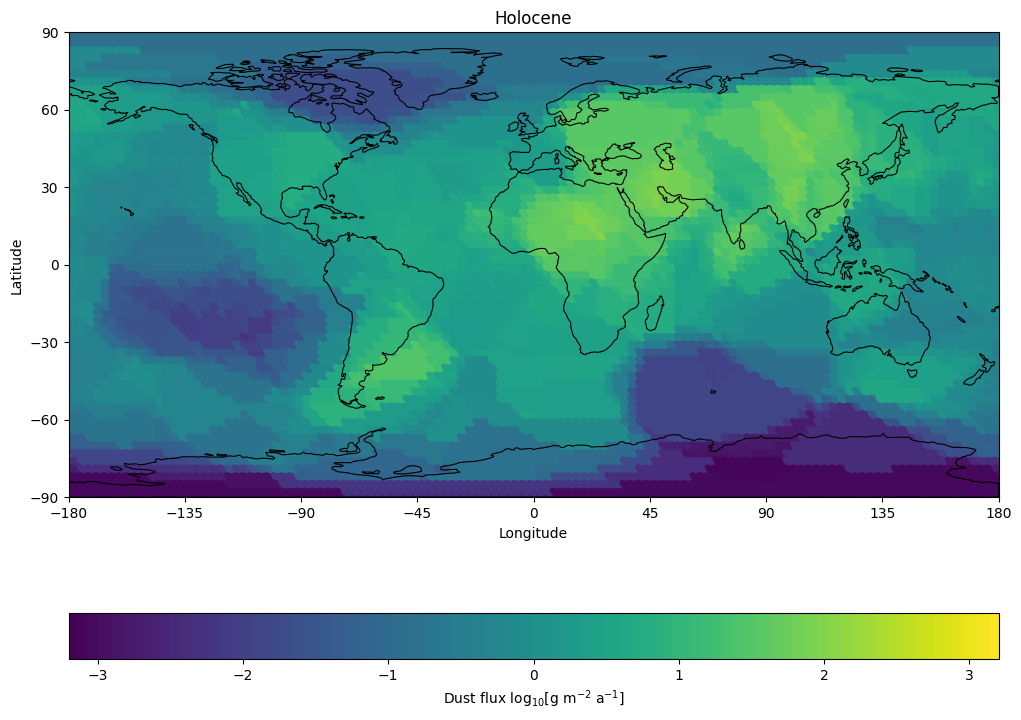

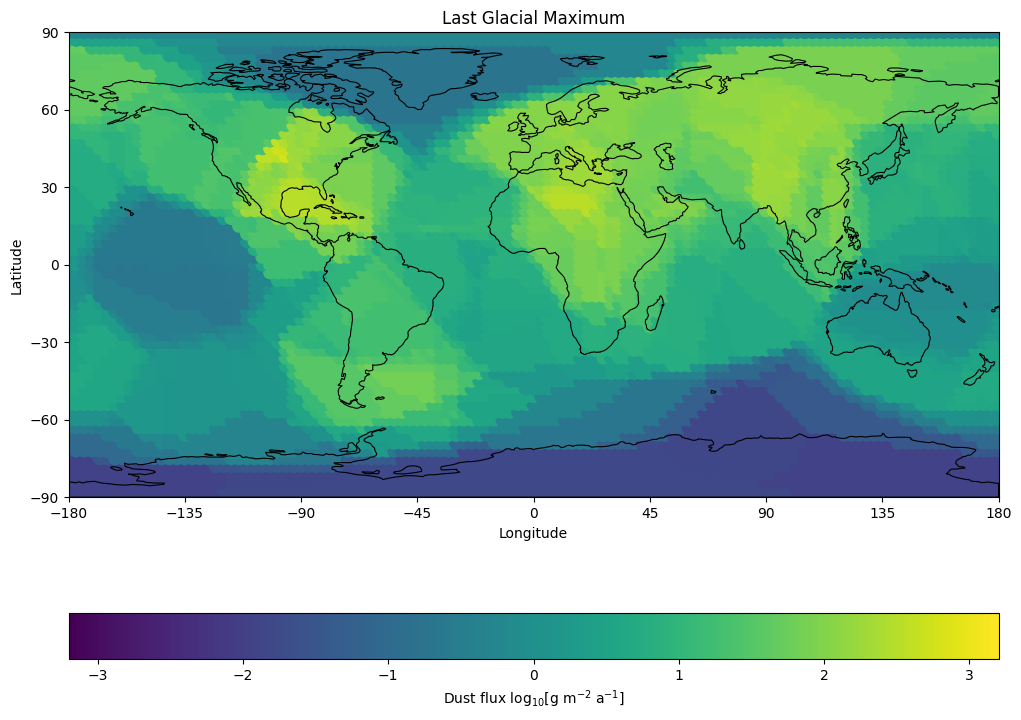

In [18]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm')

Por lo que visualizamos la diferencia de los k mas cercanos con euclidiana y geodesica, se ven diferencias en los polos

Para ver la diferencia entre la distancia euclidiana y geodesica, vamos a calcular la distancia de un punto A con todos los demas puntos

Vamos a crear una matriz con las distacias del puntoa A a B

In [82]:
cols = df_global_grid[["lon", "lat"]].values.tolist()
cols = list(map(str, cols))


In [16]:
df_ecu=pd.DataFrame(columns=cols)
df_geo=pd.DataFrame(columns=cols)

In [17]:
def coso_eclidio(row, df):
    pos1 = row["lon"], row["lat"]
    distances = df.apply(lambda x: distance_euclidean(pos1, (x["lon"], x["lat"])), axis=1)
    return pd.Series(distances, index=df.index)

def coso_geodesico(row, df):
    pos1 = row["lon"], row["lat"]
    distances = df.apply(lambda x: distance_geodesic(pos1, (x["lon"], x["lat"])), axis=1)
    return pd.Series(distances, index=df.index)




In [21]:
df_ecu = df_global_grid.apply(coso_eclidio, axis=1, args=(df_global_grid,))

In [22]:
df_geo = df_global_grid.apply(coso_geodesico, axis=1, args=(df_global_grid,))

/tmp/ipykernel_1269/1873922194.py:19: RuntimeWarning: invalid value encountered in arccos
  distance = np.arccos((np.sin(lat1)*np.sin(lat2))+(np.cos(lat1)*np.cos(lat2)*np.cos(lon1 - lon2)) )


In [66]:
df_ecu

,0,1,2,3,4,5,6,7,8,9,...,7371,7372,7373,7374,7375,7376,7377,7378,7379,7380
0,0.000000,0.052358,0.104717,0.157075,0.209433,0.261792,0.314150,0.366508,0.418867,0.471225,...,6.606493,6.652600,6.698798,6.745087,6.791463,6.837926,6.884474,6.931104,6.977816,7.024608
1,0.052358,0.000000,0.052358,0.104717,0.157075,0.209433,0.261792,0.314150,0.366508,0.418867,...,6.560480,6.606493,6.652600,6.698798,6.745087,6.791463,6.837926,6.884474,6.931104,6.977816
2,0.104717,0.052358,0.000000,0.052358,0.104717,0.157075,0.209433,0.261792,0.314150,0.366508,...,6.514563,6.560480,6.606493,6.652600,6.698798,6.745087,6.791463,6.837926,6.884474,6.931104
3,0.157075,0.104717,0.052358,0.000000,0.052358,0.104717,0.157075,0.209433,0.261792,0.314150,...,6.468744,6.514563,6.560480,6.606493,6.652600,6.698798,6.745087,6.791463,6.837926,6.884474
4,0.209433,0.157075,0.104717,0.052358,0.000000,0.052358,0.104717,0.157075,0.209433,0.261792,...,6.423025,6.468744,6.514563,6.560480,6.606493,6.652600,6.698798,6.745087,6.791463,6.837926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7376,6.837926,6.791463,6.745087,6.698798,6.652600,6.606493,6.560480,6.514563,6.468744,6.423025,...,0.261792,0.209433,0.157075,0.104717,0.052358,0.000000,0.052358,0.104717,0.157075,0.209433
7377,6.884474,6.837926,6.791463,6.745087,6.698798,6.652600,6.606493,6.560480,6.514563,6.468744,...,0.314150,0.261792,0.209433,0.157075,0.104717,0.052358,0.000000,0.052358,0.104717,0.157075
7378,6.931104,6.884474,6.837926,6.791463,6.745087,6.698798,6.652600,6.606493,6.560480,6.514563,...,0.366508,0.314150,0.261792,0.209433,0.157075,0.104717,0.052358,0.000000,0.052358,0.104717
7379,6.977816,6.931104,6.884474,6.837926,6.791463,6.745087,6.698798,6.652600,6.606493,6.560480,...,0.418867,0.366508,0.314150,0.261792,0.209433,0.157075,0.104717,0.052358,0.000000,0.052358


Restamos la distancia calculada con euclidiana con la geodesica, lo que nos data un dataframe con la diferencia de las distancias si es positivo la eclidiana es mayor y si es negativa la geodesica es mayor

In [98]:
df_dif = df_ecu - df_geo
df_dif.index = cols
df_dif.columns = cols

[-180.0, -90.0]    6.283000e+00
[-177.0, -90.0]    6.230639e+00
[-174.0, -90.0]    6.178278e+00
[-171.0, -90.0]    6.125918e+00
[-168.0, -90.0]    6.073557e+00
                       ...     
[168.0, 90.0]      6.972864e-03
[171.0, 90.0]      3.924138e-03
[174.0, 90.0]      1.744666e-03
[177.0, 90.0]      4.362574e-04
[180.0, 90.0]     -3.668177e-13
Name: [180.0, -90.0], Length: 7381, dtype: float64

Para visualizar la diferencia haremos un mapa de calor, desde el azul que sera 0 diferencia entre los metodos y rojo que sera que la diferencia es apreciable

In [84]:
df_dif = df_dif.iloc[:50, :50]
data = df_dif.values

In [86]:
cols2 = df_dif.columns


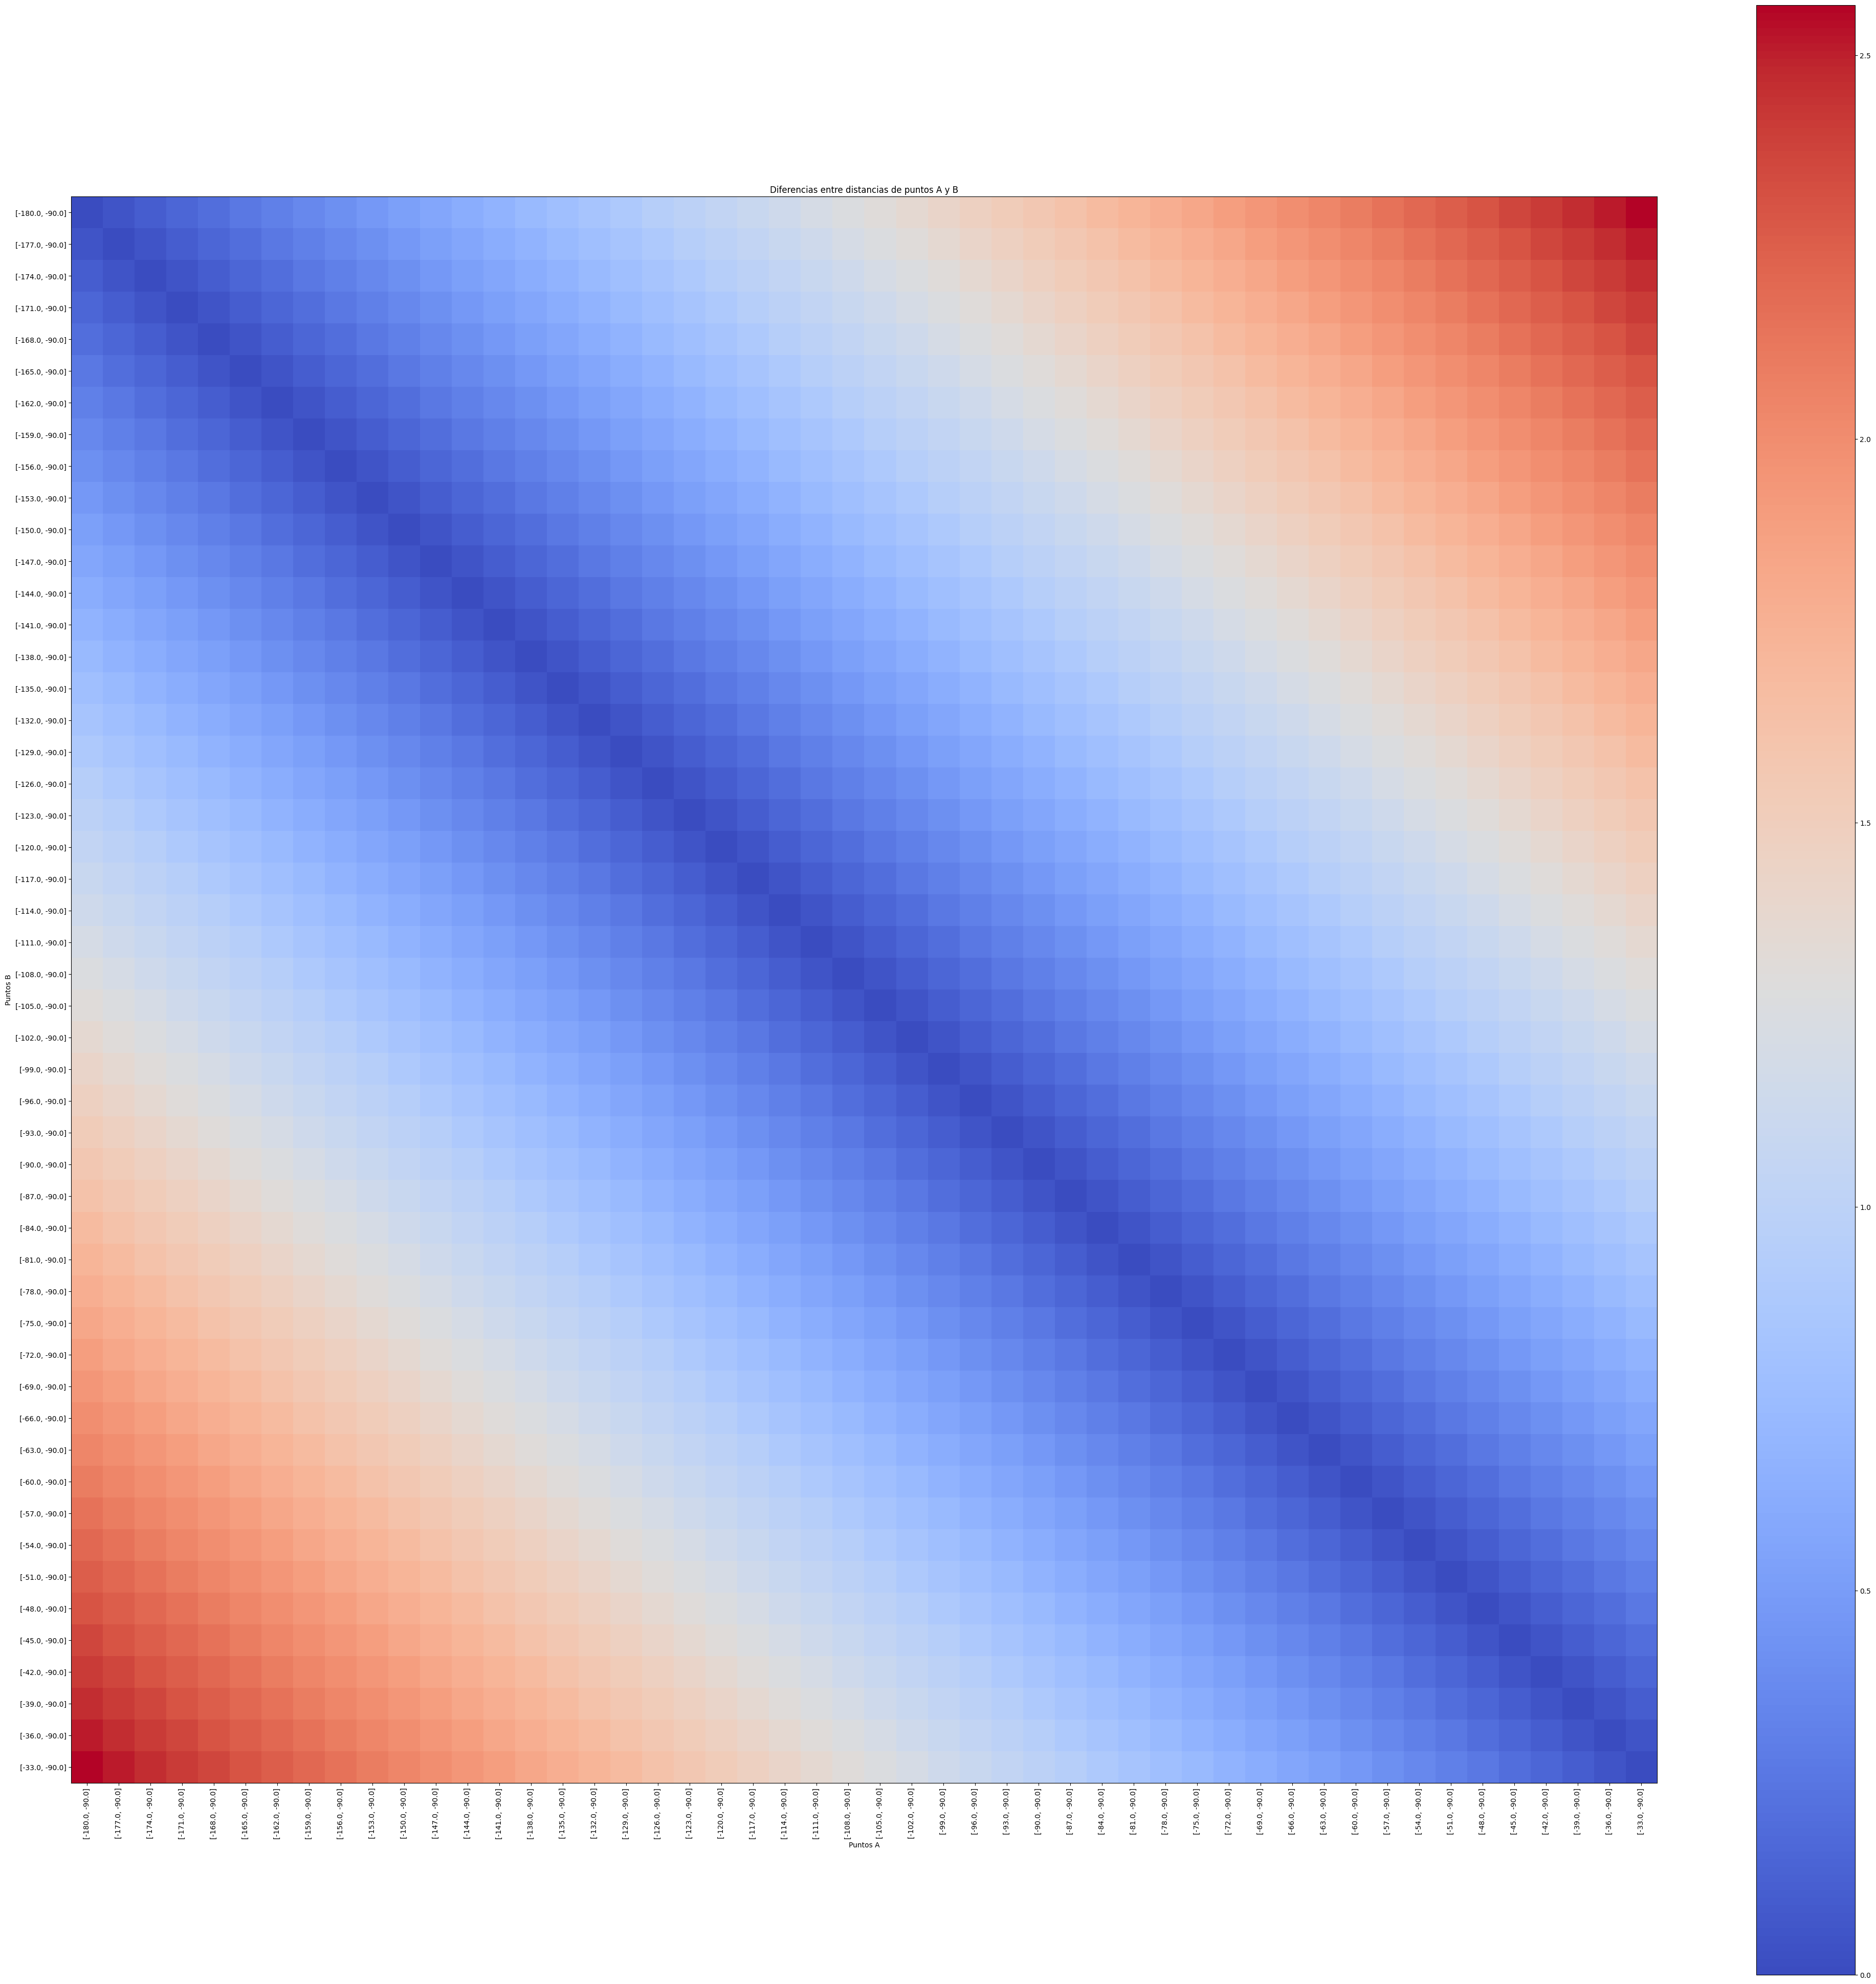

In [87]:


plt.figure(figsize=(50, 50))
heatmap = plt.imshow(data, cmap='coolwarm', interpolation='nearest')

plt.xticks(np.arange(len(cols2)), cols2, rotation=90)
plt.yticks(np.arange(len(cols2)), cols2)
plt.xlabel('Puntos A')
plt.ylabel('Puntos B')

plt.colorbar(heatmap)
plt.title('Diferencias entre distancias de puntos A y B')
plt.show()

Aqui se visualiza la diferencia entre la distancia euclidiana y geodesica, se aprecia que si movemos la lon y la lat de un punto la diferencia entre los metodos aumenta (solo tome como referencia 50 puntos pues hacerlo con los 7000 me daba error)

a) La diferencia entre las distancias son mas grandes cuando movemos al mismo tiempo la longitud y latitud, pero si dejamos alguna de ellas constante la diferencia es menor pero aun asi existe

b) El metodo más fidedigno en ambos polos es la geodesica, esto se debe a que en los polos los meridianos (son los que miden la longitud) se encuentran y estan a una menor distancia, esto se ve representado en la geodesica, sin embargo en la ecludiana no pues la distancia entre ellas se mantiene constante y no se toma en cuenta que en los polos los meridianos se intersectan.

c) En logitud 180 constante el mejor metodo sigue siendo la geodesica, pues la euclidiana no tiene en cuenta la curvatura de la tierra, sin embargo como la longitud se mantiene constante, la distorcion sera menor

d) La diferencia en los graficos de Holoceno y LGM, son mas apreciable en los polos por ejemplo en la antartica en la peninsula antartica, con la distancia ecludiana se ve verde pues en america del sur hay bastantes puntos, pero con la distancia geodesica ese verde desaparece, algo similar ocurre en el polo norte en donde el verde del mas al norte desaparece

e) Yo escogeria en este caso el numero de vecinos cercanos viendo la visualizacion, comparando con los puntos del dataset, esperando que los colores del resultado que representan el promedio de los puntos no se desvien demasiado del dataset